In [3]:
import tensorflow as tf
from pycocotools.coco import COCO
import os
import numpy as np
import matplotlib.pyplot as plt


In [4]:
from pycocotools.coco import COCO
import os

# Path to our train annotation file (since we are using train images for both training and validation)
train_labels_path = 'C:/Users/Spawtan/Pictures/Lamdba/labels.tar/publaynet/train.json'

# Load the train annotations (no separate val images)
coco_train = COCO(train_labels_path)

# Get all image IDs
image_ids = coco_train.getImgIds()

print(f"Total number of images: {len(image_ids)}")


loading annotations into memory...
Done (t=56.96s)
creating index...
index created!
Total number of images: 335703


In [5]:
from sklearn.model_selection import train_test_split

# Split the image IDs into training and validation
train_image_ids, val_image_ids = train_test_split(image_ids, test_size=0.2, random_state=42)

print(f"Number of training images: {len(train_image_ids)}")
print(f"Number of validation images: {len(val_image_ids)}")


Number of training images: 268562
Number of validation images: 67141


In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

# List of image directories
image_dirs = [
    'C:/Users/Spawtan/Pictures/Lamdba/train-0.tar/publaynet/train',
    'C:/Users/Spawtan/Pictures/Lamdba/train-1.tar/publaynet/train',
    'C:/Users/Spawtan/Pictures/Lamdba/train-2.tar/publaynet/train',
    'C:/Users/Spawtan/Pictures/Lamdba/train-3.tar/publaynet/train',
    'C:/Users/Spawtan/Pictures/Lamdba/train-4.tar/publaynet/train',
    'C:/Users/Spawtan/Pictures/Lamdba/train-5.tar/publaynet/train',
    'C:/Users/Spawtan/Pictures/Lamdba/train-6.tar/publaynet/train'
]

def pad_bboxes(bboxes, max_boxes=50):
    """
    Pad bounding boxes to the same size.
    max_boxes: The maximum number of boxes to pad to.
    """
    if len(bboxes) > max_boxes:
        bboxes = bboxes[:max_boxes]
    else:
        # Pad with zero boxes if there are fewer than max_boxes
        padding = [[0, max_boxes - len(bboxes)], [0, 0]]  # Padding for bounding boxes
        bboxes = tf.pad(bboxes, padding)
    return bboxes



def pad_masks(masks, max_masks=10):
    """
    Pad the list of masks to the same size.
    max_masks: The maximum number of masks to pad to.
    """
    if len(masks) > max_masks:
        masks = masks[:max_masks]  # Trim if there are too many masks
    padded_masks = np.zeros((max_masks, masks[0].shape[0], masks[0].shape[1], masks[0].shape[2]))  # (max_masks, height, width, channels)
    padded_masks[:len(masks)] = masks
    return padded_masks

def load_image_and_annotations(image_id, coco, image_dirs, target_size=(512, 512), max_boxes=50, max_masks=10):
    """
    Load an image, bounding boxes, and masks from a COCO dataset, and pad them.
    """
    # Load image metadata
    img_info = coco.loadImgs(image_id)[0]
    image_filename = img_info['file_name']

    # Search for the image across directories
    image_path = None
    for image_dir in image_dirs:
        possible_image_path = os.path.join(image_dir, image_filename)
        if os.path.exists(possible_image_path):
            image_path = possible_image_path
            break
    
    if image_path is None:
        raise FileNotFoundError(f"Image {image_filename} not found in any of the directories.")

    # Load and resize image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, target_size)

    # Load bounding boxes and masks
    ann_ids = coco.getAnnIds(imgIds=image_id)
    anns = coco.loadAnns(ann_ids)
    
    # Extract bounding boxes and ensure only [x_min, y_min, width, height]
    boxes = [ann['bbox'][:4] for ann in anns]  # Extract only the first 4 coordinates
    boxes = pad_bboxes(boxes, max_boxes)  # Ensure all boxes are padded to max_boxes

    # Create and pad masks
    masks = [tf.expand_dims(coco.annToMask(ann), axis=-1) for ann in anns]
    masks = [tf.image.resize(mask, target_size) for mask in masks]
    masks = pad_masks(masks, max_masks=max_masks)  # Pad masks

    return image, boxes, masks


In [7]:
def data_generator(image_ids, coco, image_dirs, max_boxes=50, max_masks=10):
    for image_id in image_ids:
        image, boxes, masks = load_image_and_annotations(image_id, coco, image_dirs, max_boxes=max_boxes, max_masks=max_masks)
        yield image, boxes, masks


In [8]:
# Define max_boxes and max_masks
max_boxes = 50
max_masks = 10

# Training dataset pipeline
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(train_image_ids, coco_train, image_dirs, max_boxes=max_boxes, max_masks=max_masks),
    output_signature=(
        tf.TensorSpec(shape=(512, 512, 3), dtype=tf.float32),  # Resized images
        tf.TensorSpec(shape=(max_boxes, 4), dtype=tf.float32),  # Padded bounding boxes
        tf.TensorSpec(shape=(max_masks, 512, 512, 1), dtype=tf.float32)  # Padded masks
    )
)

# Validation dataset pipeline
val_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(val_image_ids, coco_train, image_dirs, max_boxes=max_boxes, max_masks=max_masks),
    output_signature=(
        tf.TensorSpec(shape=(512, 512, 3), dtype=tf.float32),  # Resized images
        tf.TensorSpec(shape=(max_boxes, 4), dtype=tf.float32),  # Padded bounding boxes
        tf.TensorSpec(shape=(max_masks, 512, 512, 1), dtype=tf.float32)  # Padded masks
    )
)

# Shuffle and batch the training dataset
batch_size = 8
train_dataset = train_dataset.shuffle(buffer_size=100).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# Batch the validation dataset
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# Verify the shapes of a batch
for image_batch, boxes_batch, masks_batch in train_dataset.take(1):
    print(f"Train - Image batch shape: {image_batch.shape}")
    print(f"Train - Bounding boxes batch shape: {boxes_batch.shape}")
    print(f"Train - Masks batch shape: {masks_batch.shape}")

for image_batch, boxes_batch, masks_batch in val_dataset.take(1):
    print(f"Val - Image batch shape: {image_batch.shape}")
    print(f"Val - Bounding boxes batch shape: {boxes_batch.shape}")
    print(f"Val - Masks batch shape: {masks_batch.shape}")


Train - Image batch shape: (8, 512, 512, 3)
Train - Bounding boxes batch shape: (8, 50, 4)
Train - Masks batch shape: (8, 10, 512, 512, 1)
Val - Image batch shape: (8, 512, 512, 3)
Val - Bounding boxes batch shape: (8, 50, 4)
Val - Masks batch shape: (8, 10, 512, 512, 1)


In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import TimeDistributed
import numpy as np

def build_resnet_backbone(input_image):
    """Build the ResNet backbone for Mask R-CNN."""
    # Remove the batch size from the input shape
    input_shape = input_image.shape[2:]
    
    # Create a ResNet50 model without the top layers
    base_model = tf.keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )
    
    # Wrap the entire model in a TimeDistributed layer
    wrapped_model = tf.keras.layers.TimeDistributed(base_model)(input_image)
    
    return wrapped_model

def build_rpn(backbone_output, num_anchors):
    """Build the Region Proposal Network (RPN)."""
    shared_conv = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu'))(backbone_output)
    rpn_class_logits = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(2 * num_anchors, (1, 1), activation='linear'))(shared_conv)
    rpn_bbox = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(4 * num_anchors, (1, 1), activation='linear'))(shared_conv)
    return rpn_class_logits, rpn_bbox

def generate_anchors(input_shape, feature_map_shape, scales, ratios):
    """Generate anchor boxes."""
    heights, widths = np.meshgrid(np.arange(feature_map_shape[0]), np.arange(feature_map_shape[1]), indexing='ij')
    centers_y = (heights + 0.5) / feature_map_shape[0] * input_shape[0]
    centers_x = (widths + 0.5) / feature_map_shape[1] * input_shape[1]
    
    centers = np.stack([centers_y, centers_x], axis=-1)
    centers = np.expand_dims(centers, axis=2)
    
    scales = np.array(scales)
    ratios = np.array(ratios)
    
    scale_grid, ratio_grid = np.meshgrid(scales, ratios, indexing='ij')
    scale_ratio_pairs = np.stack([scale_grid.ravel(), ratio_grid.ravel()], axis=-1)
    
    ws = scale_ratio_pairs[:, 0] * np.sqrt(scale_ratio_pairs[:, 1])
    hs = scale_ratio_pairs[:, 0] / np.sqrt(scale_ratio_pairs[:, 1])
    
    anchors = np.stack([
        centers[:, :, :, 0] - 0.5 * hs,
        centers[:, :, :, 1] - 0.5 * ws,
        centers[:, :, :, 0] + 0.5 * hs,
        centers[:, :, :, 1] + 0.5 * ws
    ], axis=-1)
    
    anchors = anchors.reshape((-1, 4))
    return tf.convert_to_tensor(anchors, dtype=tf.float32)

def generate_proposals(rpn_class_logits, rpn_bbox, anchors, max_proposals=1000, nms_threshold=0.7):
    """Generate proposals from RPN outputs."""
    batch_size = tf.shape(rpn_class_logits)[0]
    
    # Reshape logits and apply softmax to get objectness scores
    scores = tf.nn.softmax(tf.reshape(rpn_class_logits, [batch_size, -1, 2]))[:, :, 1]
    
    # Reshape bbox deltas
    deltas = tf.reshape(rpn_bbox, [batch_size, -1, 4])
    
    # Apply bounding box deltas to anchors to get proposal coordinates
    proposals = apply_box_deltas(anchors, deltas)
    
    # Clip proposals to image boundaries (assuming image size is 512x512)
    proposals = clip_boxes(proposals, [0, 0, 512, 512])
    
    def nms_and_pad(args):
        props, scores = args
        indices = tf.image.non_max_suppression(
            props,
            scores,
            max_output_size=max_proposals,
            iou_threshold=nms_threshold
        )
        selected_props = tf.gather(props, indices)
        padded_props = tf.pad(
            selected_props,
            [[0, max_proposals - tf.shape(selected_props)[0]], [0, 0]],
            mode='CONSTANT',
            constant_values=0
        )
        return padded_props

    # Apply NMS and padding for each image in the batch
    final_proposals = tf.map_fn(nms_and_pad, (proposals, scores), dtype=tf.float32)
    
    return final_proposals

def apply_box_deltas(boxes, deltas):
    """Apply bounding box deltas to anchor boxes."""
    height = boxes[:, 2] - boxes[:, 0]
    width = boxes[:, 3] - boxes[:, 1]
    center_y = boxes[:, 0] + 0.5 * height
    center_x = boxes[:, 1] + 0.5 * width

    center_y += deltas[:, :, 0] * height
    center_x += deltas[:, :, 1] * width
    height *= tf.exp(deltas[:, :, 2])
    width *= tf.exp(deltas[:, :, 3])

    y1 = center_y - 0.5 * height
    x1 = center_x - 0.5 * width
    y2 = y1 + height
    x2 = x1 + width

    return tf.stack([y1, x1, y2, x2], axis=-1)

def clip_boxes(boxes, window):
    """Clip boxes to image boundaries."""
    wy1, wx1, wy2, wx2 = tf.unstack(window, axis=0)
    y1, x1, y2, x2 = tf.unstack(boxes, axis=-1)
    y1 = tf.maximum(tf.minimum(y1, wy2), wy1)
    x1 = tf.maximum(tf.minimum(x1, wx2), wx1)
    y2 = tf.maximum(tf.minimum(y2, wy2), wy1)
    x2 = tf.maximum(tf.minimum(x2, wx2), wx1)
    clipped = tf.stack([y1, x1, y2, x2], axis=-1)
    return clipped

class ROIALignLayer(layers.Layer):
    def __init__(self, pool_size, **kwargs):
        super(ROIALignLayer, self).__init__(**kwargs)
        self.pool_size = pool_size

    def call(self, inputs):
        feature_map, rois = inputs
        batch_size = tf.shape(feature_map)[0]
        
        # Reshape ROIs to (batch_size * num_rois, 4)
        rois_reshaped = tf.reshape(rois, [-1, 4])
        
        # Create batch indices
        batch_indices = tf.repeat(tf.range(batch_size), tf.shape(rois)[1])
        
        # Perform ROI Align
        roi_pooled = tf.image.crop_and_resize(
            feature_map,
            rois_reshaped,
            box_indices=batch_indices,
            crop_size=(self.pool_size, self.pool_size)
        )
        
        # Reshape output to (batch_size, num_rois, pool_size, pool_size, channels)
        output_shape = tf.concat([tf.shape(rois)[:2], [self.pool_size, self.pool_size, tf.shape(feature_map)[-1]]], axis=0)
        roi_pooled = tf.reshape(roi_pooled, output_shape)
        
        return roi_pooled

    def compute_output_shape(self, input_shape):
        feature_map_shape, rois_shape = input_shape
        return (feature_map_shape[0], rois_shape[1], self.pool_size, self.pool_size, feature_map_shape[-1])

def build_detection_head(roi_pooled, num_classes):
    """Build the detection head for classification and bounding box regression."""
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(1024, (roi_pooled.shape[2], roi_pooled.shape[3])))(roi_pooled)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten())(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1024, activation='relu'))(x)
    class_logits = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_classes, activation='softmax'))(x)
    bbox = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_classes * 4))(x)
    return class_logits, bbox

def build_mask_head(roi_pooled, num_classes, pool_size):
    """Build the mask head for Mask R-CNN."""
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'))(roi_pooled)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'))(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'))(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), activation='relu'))(x)
    mask = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(num_classes, (1, 1), activation='sigmoid'))(x)
    return mask

def build_mask_rcnn(input_shape=(None, 512, 512, 3), num_classes=5, num_anchors=9, pool_size=7, max_proposals=300):
    """Build the Mask R-CNN model."""
    input_image = tf.keras.layers.Input(shape=input_shape)
    
    backbone_output = build_resnet_backbone(input_image)
    rpn_class_logits, rpn_bbox = build_rpn(backbone_output, num_anchors)
    
    # Generate anchors
    anchors = generate_anchors(input_shape[1:3], backbone_output.shape[2:4], scales=[32, 64, 128, 256, 512], ratios=[0.5, 1, 2])
    
    # Use the RPN outputs to generate proposals
    proposals = layers.Lambda(
        lambda x: generate_proposals(x[0], x[1], anchors, max_proposals),
        output_shape=(max_proposals, 4)
    )([rpn_class_logits, rpn_bbox])
    
    # ROI Align
    roi_pooled = ROIALignLayer(pool_size)([backbone_output, proposals])
    
    # Detection head
    class_logits, bbox = build_detection_head(roi_pooled, num_classes)
    
    # Mask head
    mask = build_mask_head(roi_pooled, num_classes, pool_size)
    
    model = tf.keras.models.Model(
        inputs=input_image,
        outputs={
            'rpn_class_logits': rpn_class_logits,
            'rpn_bbox': rpn_bbox,
            'proposals': proposals,
            'class_logits': class_logits,
            'bbox': bbox,
            'mask': mask
        }
    )
    return model

In [13]:
import tensorflow as tf
import os

# Set up GPU memory growth to avoid allocating all memory at once
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

# Set the default float type to float32 for better performance
tf.keras.backend.set_floatx('float32')

# Build the Mask R-CNN model
with tf.device('/GPU:0'):
    mask_rcnn_model = build_mask_rcnn(input_shape=(512, 512, 3), num_classes=5)

# Define custom loss functions
@tf.function
def rpn_class_loss(y_true, y_pred):
    """RPN anchor classifier loss."""
    y_true = tf.cast(y_true, 'int32')
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    mask = tf.cast(tf.not_equal(y_true, -1), tf.float32)
    loss = loss * mask
    return tf.reduce_sum(loss) / tf.maximum(tf.reduce_sum(mask), 1)

@tf.function
def rpn_bbox_loss(y_true, y_pred):
    """RPN bounding box loss."""
    loss = tf.keras.losses.Huber(delta=1.0)(y_true, y_pred)
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = loss * mask
    return tf.reduce_sum(loss) / tf.maximum(tf.reduce_sum(mask), 1)

@tf.function
def mrcnn_class_loss(y_true, y_pred):
    """Mask R-CNN classifier loss."""
    y_true = tf.cast(y_true, 'int32')
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = loss * mask
    return tf.reduce_sum(loss) / tf.maximum(tf.reduce_sum(mask), 1)

@tf.function
def mrcnn_bbox_loss(y_true, y_pred):
    """Mask R-CNN bounding box refinement loss."""
    loss = tf.keras.losses.Huber(delta=1.0)(y_true, y_pred)
    mask = tf.cast(tf.not_equal(y_true[:, :, 0], 0), tf.float32)
    loss = loss * tf.expand_dims(mask, axis=-1)
    return tf.reduce_sum(loss) / tf.maximum(tf.reduce_sum(mask), 1)

@tf.function
def mrcnn_mask_loss(y_true, y_pred):
    """Mask R-CNN mask loss."""
    loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    mask = tf.cast(tf.not_equal(tf.reduce_sum(y_true, axis=-1), 0), tf.float32)
    loss = loss * mask
    return tf.reduce_sum(loss) / tf.maximum(tf.reduce_sum(mask), 1)

# Configure the dataset to use GPU
batch_size = 1  # Reduced batch size
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Get the shape of a single batch
for images, _ in train_dataset.take(1):
    input_shape = images.shape[1:]
    break

print(f"Input shape: {input_shape}")

# Build the Mask R-CNN model
with tf.device('/GPU:0'):
    mask_rcnn_model = build_mask_rcnn(input_shape=input_shape, num_classes=5)

# Compile the model
mask_rcnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss={
        'rpn_class_logits': rpn_class_loss,
        'rpn_bbox': rpn_bbox_loss,
        'class_logits': mrcnn_class_loss,
        'bbox': mrcnn_bbox_loss,
        'mask': mrcnn_mask_loss
    },
    loss_weights={
        'rpn_class_logits': 1.0,
        'rpn_bbox': 1.0,
        'class_logits': 1.0,
        'bbox': 1.0,
        'mask': 1.0
    }
)

# Train the model
with tf.device('/GPU:0'):
    history = mask_rcnn_model.fit(
        train_dataset,
        epochs=10,
        steps_per_epoch=1000,
        validation_data=val_dataset,
        validation_steps=200
    )

# Save the model
mask_rcnn_model.save('mask_rcnn_model.h5')

ValueError: too many values to unpack (expected 2)

### use  this subset of this train

In [17]:
import tensorflow as tf
import os

# Set up GPU memory growth to avoid allocating all memory at once
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

# Set the default float type to float32 for better performance
tf.keras.backend.set_floatx('float32')
# Build the Mask R-CNN model
with tf.device('/GPU:0'):
    mask_rcnn_model = build_mask_rcnn(input_shape=(512, 512, 3), num_classes=5)

# Define custom loss functions
@tf.function
def rpn_class_loss(y_true, y_pred):
    """RPN anchor classifier loss."""
    y_true = tf.cast(y_true, 'int32')
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    mask = tf.cast(tf.not_equal(y_true, -1), tf.float32)
    loss = loss * mask
    return tf.reduce_sum(loss) / tf.maximum(tf.reduce_sum(mask), 1)

@tf.function
def rpn_bbox_loss(y_true, y_pred):
    """RPN bounding box loss."""
    loss = tf.keras.losses.Huber(delta=1.0)(y_true, y_pred)
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = loss * mask
    return tf.reduce_sum(loss) / tf.maximum(tf.reduce_sum(mask), 1)

@tf.function
def mrcnn_class_loss(y_true, y_pred):
    """Mask R-CNN classifier loss."""
    y_true = tf.cast(y_true, 'int32')
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = loss * mask
    return tf.reduce_sum(loss) / tf.maximum(tf.reduce_sum(mask), 1)

@tf.function
def mrcnn_bbox_loss(y_true, y_pred):
    """Mask R-CNN bounding box refinement loss."""
    loss = tf.keras.losses.Huber(delta=1.0)(y_true, y_pred)
    mask = tf.cast(tf.not_equal(y_true[:, :, 0], 0), tf.float32)
    loss = loss * tf.expand_dims(mask, axis=-1)
    return tf.reduce_sum(loss) / tf.maximum(tf.reduce_sum(mask), 1)

@tf.function
def mrcnn_mask_loss(y_true, y_pred):
    """Mask R-CNN mask loss."""
    loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    mask = tf.cast(tf.not_equal(tf.reduce_sum(y_true, axis=-1), 0), tf.float32)
    loss = loss * mask
    return tf.reduce_sum(loss) / tf.maximum(tf.reduce_sum(mask), 1)


def create_subset(dataset, num_samples):
    return dataset.take(num_samples)

# Create small subsets of your data
num_train_samples = 100  # Adjust this number based on your memory constraints
num_val_samples = 20

train_subset = create_subset(train_dataset, num_train_samples)
val_subset = create_subset(val_dataset, num_val_samples)

# Function to reshape the input data
def reshape_data(images, boxes, masks):
    # Ensure images have shape (None, 512, 512, 3)
    images = tf.ensure_shape(images, (None, 512, 512, 3))
    
    # Reshape boxes to (batch_size, num_boxes, 4)
    boxes = tf.reshape(boxes, [-1, 50, 4])
    
    # Reshape masks to (batch_size, num_masks, height, width, 1)
    masks = tf.reshape(masks, [-1, 10, 512, 512, 1])
    
    return images, boxes, masks

# Apply the reshape function to the dataset
train_subset = train_subset.map(reshape_data)
val_subset = val_subset.map(reshape_data)

# Configure the dataset to use GPU
batch_size = 1  # Reduced batch size
train_subset = train_subset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_subset = val_subset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Get the shape of the input images
for images, boxes, masks in train_subset.take(1):
    input_shape = images.shape[2:]
    break

print(f"Input shape: {input_shape}")

def reshape_data(images, boxes, masks):
    print("Images shape:", images.shape)
    print("Boxes shape:", boxes.shape)
    print("Masks shape:", masks.shape)



# Build the Mask R-CNN model
with tf.device('/GPU:0'):
    mask_rcnn_model = build_mask_rcnn(input_shape=(None, 512, 512, 3), num_classes=5)

# Compile the model
mask_rcnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss={
        'rpn_class_logits': rpn_class_loss,
        'rpn_bbox': rpn_bbox_loss,
        'class_logits': mrcnn_class_loss,
        'bbox': mrcnn_bbox_loss,
        'mask': mrcnn_mask_loss
    },
    loss_weights={
        'rpn_class_logits': 1.0,
        'rpn_bbox': 1.0,
        'class_logits': 1.0,
        'bbox': 1.0,
        'mask': 1.0
    }
)

# Train the model
with tf.device('/GPU:0'):
    history = mask_rcnn_model.fit(
        train_subset,
        epochs=5,  # Reduced number of epochs
        steps_per_epoch=num_train_samples // batch_size,
        validation_data=val_subset,
        validation_steps=num_val_samples // batch_size
    )

# Save the model
mask_rcnn_model.save('mask_rcnn_model_subset.h5')

ValueError: `input_shape` must be a tuple of three integers.

### Alternative

In [18]:
import tensorflow as tf

# Download the model
model_url = "http://download.tensorflow.org/models/object_detection/tf2/20200711/mask_rcnn_inception_resnet_v2_1024x1024_coco17_gpu-8.tar.gz"
model_name = model_url.split('/')[-1]
model_name = model_name.split('.')[0]

tf.keras.utils.get_file(model_name, model_url, untar=True)

484546405/484546405 ━━━━━━━━━━━━━━━━━━━━ 17s 0us/step


'C:\\Users\\Spawtan\\.keras\\datasets\\mask_rcnn_inception_resnet_v2_1024x1024_coco17_gpu-8'

In [19]:
import os
from object_detection.utils import config_util
from object_detection.builders import model_builder

# Path to the downloaded model
model_dir = os.path.join(os.getcwd(), model_name)
pipeline_config_path = os.path.join(model_dir, 'pipeline.config')

# Load the configuration
configs = config_util.get_configs_from_pipeline_file(pipeline_config_path)
model_config = configs['model']

# Build the model
detection_model = model_builder.build(model_config=model_config, is_training=True)

# Restore the pre-trained weights
checkpoint = tf.train.Checkpoint(model=detection_model)
checkpoint.restore(os.path.join(model_dir, 'checkpoint', 'ckpt-0')).expect_partial()

TypeError: Descriptors cannot be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

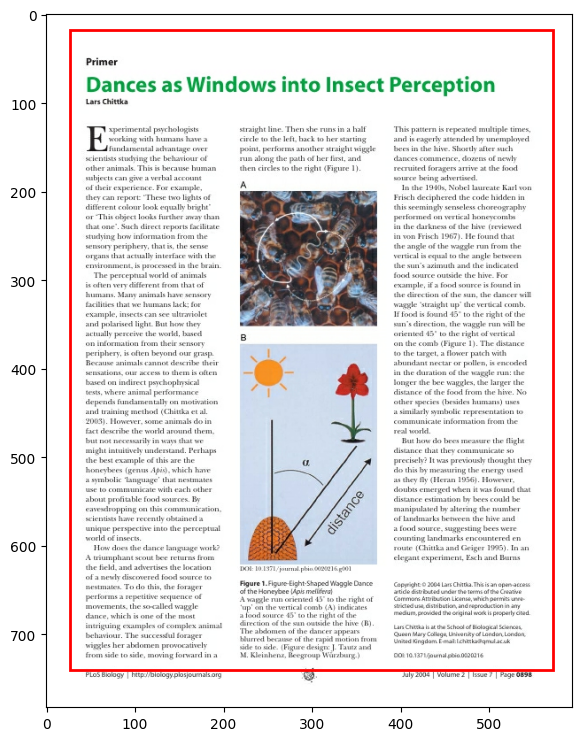

Number of detections: 100
Detection Boxes: [[0.02269372 0.04426092 0.9462837  0.96353835]
 [0.         0.         0.9845666  0.44161627]
 [0.465526   0.363164   0.795504   0.6231311 ]
 [0.11295313 0.01574847 0.91386324 0.62528276]
 [0.46384186 0.36372703 0.8039934  0.6244422 ]
 [0.24791408 0.35505426 0.46245152 0.6390308 ]
 [0.05801767 0.         1.         1.        ]
 [0.36545715 0.15698811 0.954772   0.8617289 ]
 [0.         0.         0.9945891  0.98388076]
 [0.4647789  0.3727557  0.8022851  0.62059   ]
 [0.33677188 0.4875776  0.45039007 0.61344415]
 [0.44545552 0.         1.         1.        ]
 [0.58019614 0.545452   0.6189927  0.6189189 ]
 [0.35413882 0.5149462  0.41439298 0.5530822 ]
 [0.01815414 0.46734354 1.         1.        ]
 [0.4940306  0.39169973 0.54100645 0.4588802 ]
 [0.2532807  0.33864623 0.46671402 0.6350599 ]
 [0.04233795 0.         0.7851141  1.        ]
 [0.35369465 0.5711781  0.41641906 0.61093533]
 [0.         0.         0.98128533 0.4351349 ]
 [0.7278086  0.38

In [34]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load the model
model = hub.load("https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1")

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

def run_detector(detector, img):
    # Convert the image to the range [0, 255] and cast to tf.uint8
    img_uint8 = tf.image.convert_image_dtype(img, tf.uint8)[tf.newaxis, ...]
    
    result = detector(img_uint8)
    result = {key: value.numpy() for key, value in result.items()}
    return result

def display_image_with_boxes(image, boxes, scores, threshold=0.5):
    """
    Display image with bounding boxes. Only display boxes with scores above the threshold.
    """
    image_height, image_width, _ = image.shape  # Get the image dimensions
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)

    # Iterate through all detected boxes and draw them
    for i in range(boxes.shape[0]):
        if scores[i] >= threshold:
            # Get the normalized box coordinates (values between 0 and 1)
            y1, x1, y2, x2 = boxes[i]

            # Convert normalized coordinates to absolute coordinates
            y1 = int(y1 * image_height)
            x1 = int(x1 * image_width)
            y2 = int(y2 * image_height)
            x2 = int(x2 * image_width)

            # Create a rectangle patch
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none')

            # Add the rectangle to the plot
            ax.add_patch(rect)

    plt.show()

# Example usage
image_path = r"C:\Users\Spawtan\Pictures\Lamdba\train-0.tar\publaynet\train\PMC449901_00000.jpg"
image = load_image(image_path)
results = run_detector(model, image)

# Check if results contain any boxes
if 'detection_boxes' in results and len(results['detection_boxes']) > 0:
    # Call this after detecting objects in the image
    boxes = results['detection_boxes'][0]  # Shape [num_detections, 4]
    scores = results['detection_scores'][0]  # Shape [num_detections]
    image_np = image.numpy()  # Convert the image tensor to numpy array

    # Display the image with boxes and a score threshold of 0.5
    display_image_with_boxes(image_np, boxes, scores, threshold=0.3)
else:
    print("No objects detected in the image.")

print(f"Number of detections: {boxes.shape[0]}")

print("Detection Boxes:", boxes)
print("Detection Scores:", scores)
